# Artificial Neural Networks

In this work, we will code an ANN based on the graph representation of the ANN.  
If you want to take a look at a easy-to-understand but in detail explanation of what is being code, please read the 4 chapters you will find in this [review](https://github.com/PabloRR100/Artificial-Neural-Networks).

In [1]:
# Let's leave out libraries imported
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprop
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
np.random.seed(2017)

## The graph approach

Previously, on this [Notebook](https://github.com/PabloRR100/Artificial-Neural-Networks/blob/master/ANN%20from%20Scratch.ipynb) we already had coded from scratch one Neural Network.  
The difference is that at that time, we coded in a really simple way in order to explain things, but we didn't go into how things we really working.  

The same Neural Network we have been always working with, can be easy represented in a Graph form like in the next figure. You can see the process to reach the graph structure [here](https://github.com/PabloRR100/Artificial-Neural-Networks/blob/master/Documentation/4.%20Neural%20Networks%20-%20Backpropagation%20Dimensionality%20Understanding.pdf)

<img src='./Images/ANN - Graph.png'>

In here we can see different parts or components. It is explained very in detail in the document. Here we will just mention them, and see their dimensionality given an input X of 2 variables and 4 observations. Therefore, X.shape = (4,2).

__Add Gates:__
In the forwar pass, add gates act adding the inputs to compute the output. In the backward pass, add gates act as 'distributors'. 
<img src='./Images/addGate 1.png'>

In [2]:
class AddGate:
    '''
    Gate that performs addition between vectors --> They are gradient distributors
    '''
    def forward(self, q, b):
        # Compute the sumation q + b = r
        return q + b

    def backward(self, q, b, dJ):
        # Compute the chain rule 
        dq = dJ * np.ones_like(q) # Element-wise multiplication                                        # dJ/dq = (dJ/dr)·(dr/dq) = (dJ/dr)·1 --> Eq. B2
        ones = np.ones((1, dJ.shape[0]), dtype=np.float64)
        db = np.dot(ones, dJ)    # dJ/db = (dJ/dr)·(dr/db) = (dJ/dr)·1 --> Eq. B3
        return dq, db 

__Multiply Gates:__ In the forward pass, multiply gates act multiplying the inputs to compute the output. In the bckward pass, multiply gates act as 'switchers':
<img src='./Images/mulGate 2.png'>
<img src='./Images/mulGate 2-2.png'>

In [3]:
class MultiplyGate:
    '''
    Gate that performs multiplication between vectors --> They are gradient switchers
    '''
    def forward(self, X, W):
        # Compute the matrix multiplication q = X·W
        q = np.dot(X, W) 
        return q
    '''
    def backward(self, W, X, dJ):
        # Compute the chain rule (compute the bottom gradient, given the top gradient)
        dX = np.dot(dJ, np.transpose(W)) # dJ/dx = (dJ/dq)·(dq/dW) # dq/dX = transpose(W) --> Eq. B4
        dW = np.dot(np.transpose(X), dJ) # dJ/dW = (dJ/dq)·(dq/dX) # dq/dX = transpose(X) --> Eq. B5
        return dW, dX
    '''
    def backward(self, X, W, dJ):
        # Compute the chain rule (compute the bottom gradient, given the top gradient)
        dX = np.dot(dJ, W.T)  # dJ/dx = (dJ/dq)·(dq/dW) # dq/dX = transpose(W) --> Eq. B4
        dW = np.dot(X.T, dJ)  # dJ/dW = (dJ/dq)·(dq/dX) # dq/dX = transpose(X) --> Eq. B5
        return dX, dW

__Layers:__ In forward pass layers apply their called 'activaction' function (sigmoid is used in this case) to the input to compute the output. In the backward pass, Layers compute de derivative of the activaction function as the local gradient, times de top gradient to compute the final bottom gradient
<img src='./Images/layerGate.png'>

In [4]:
class Sigmoid:
    '''
    Neuron layer with the ability of applying a sigmoid function to its inputs
    '''
    def forward(self, X):
        # Apply the sigmpoid function     z = sigmoid(r)
        return 1.0 / (1.0 + np.exp(-X))             

    def backward(self, X, back_prop):
        # Compute the chain rule multiplying by its own derivative
        deriv = self.forward(X)                     # d(sigmoid(r)) 
        return (1.0 - deriv) * deriv * back_prop    # dJ/dr = (dJ/dz)·(dz/dr) = back_prop * dsigmoid --> Eq.B6


class Tanh:
    '''
    Neuron layer with the ability of applying a tanh function to its inputs
    '''
    # Apply the tanh function             z = tanh(r)
    def forward(self, X):
        return np.tanh(X)                           

    def backward(self, X, back_prop):
        # Compute the chain rule multiplying by its own derivative
        J = self.forward(X)                         # d(tanh(r))
        return (1.0 - np.square(J)) * back_prop     # dJ/dr = (dJ/dz)·(dz/dr) = back_prop * dtanh --> Eq.B6
    

__Cost Function:__ In forward pass, the 'Cost' block compute the errors between the values obtained in the forward pass of the whole network, and the y values that they should be. In the backward pass, the Cost function stablish the __top_diff__ meaning that from that one will start the whole backpropagating process.

In [5]:
class Cost:
    '''
    Class to calculate the cost based on the error commited when predicting
    '''
    def __init__(self, y_hat):
        # Receive the vector comming from the NN object
        self.y_hat = y_hat
    
    def loss(self, y_hat, y):   # Forward
        # Compute the sum of square errors to get the cost
        J = np.sum(np.square(y - y_hat))
        return J
    
    def diff(self, y):          # Backward
        # Compute the derivative of our cost to start the backProp process
        dJ = (-(y - self.y_hat)) 
        return dJ                       # return top_diff
        

## Neural Network Structure

Now we have to compute our Neural Network, displayed in the next picture to recap, creating them with the parts in order to achieve the Grapch Architecture proposed at the beginning of this work.
<img src='./Images/ANN Structure.png'>

In [6]:
class Net:
    '''
    Net that contains [Inputs, Gates, Layers, Activation Functions, Outputs]
    '''
    def __init__(self, inputLayerSize, hiddenLayerSize, outputLayerSize):
        # Random initialization of the weights. 
        # Our Matrix W has to convert from input dimension to layer dimension
        self.inputLayerSize  = inputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        self.outputLayerSize = outputLayerSize
        self.counter = 0
        
        self.W1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
        self.b1 = np.random.randn(self.hiddenLayerSize).reshape(1, -1)
        self.b2 = np.random.randn(self.outputLayerSize).reshape(1, -1)
        self.XW1  = 0
        self.z2   = 0
        self.a2   = 0
        self.a2W2 = 0
        self.z3   = 0
        self.cost = []
        '''
        # Create a matrix per layer for W and a vector per layer for b
        for i in range(len(self.layers_dim)-1):
            self.W.append(np.random.randn(self.layers_dim[i], self.layers_dim[i+1]) / np.sqrt(self.layers_dim[i]))
            self.b.append(np.random.randn(self.layers_dim[i+1]).reshape(1, self.layers_dim[i+1]))
        '''
            
        
    def feed_forward(self, X):
        '''
        Forward propagation of the input to get our prediction y_hat (or z)
        Definition of how or neural network computes
        '''        
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer   = Sigmoid()
        
        # Now apply all the forward process for every neuron in the layer
        self.XW1   = mulGate.forward(X, self.W1)            # Eq. F1
        self.z2    = addGate.forward(self.XW1, self.b1)     # Eq. F2
        self.a2    = layer.forward(self.z2)                 # Eq. F3
        self.a2W2  = mulGate.forward(self.a2, self.W2)      # Eq. F4
        self.z3    = addGate.forward(self.a2W2, self.b2)    # Eq. F5       
        return self.z3
        
        
    def calculate_loss(self, z, y):
        '''
        Forward propagation to evaluate how well our model is doing
        '''
        costOutput = Cost(z)
        return costOutput.loss(z, y)                 # Eq. F6


    def train(self, X, y, epochs=20000, learning_rate=0.01, reg_lambda=0.01, print_loss=False):
        '''
        Batch gradient descent using the backpropagation algorithms
        '''
        mulGate    = MultiplyGate()
        addGate    = AddGate()
        layer      = Sigmoid()
    
        for epoch in range(epochs):           
            
            self.counter += 1           # Control Variable
            # Forward propagation
            z = self.feed_forward(X)  # Forward and update the value of all the variables
            costOutput = Cost(z)
            
            # Cost
            J = self.calculate_loss(z, y)
            self.cost.append(J)

            # Backward propagation
            top_diff   = costOutput.diff(y)                             # Eq. B1
            da2W2, db2 = addGate.backward(self.a2W2, self.b2, top_diff) # Eq. B2 + B3
            da2, dW2   = mulGate.backward(self.a2, self.W2, da2W2)      # Eq. B4 + B5
                # '''Layer'''
            dz2        = layer.backward(self.z2, da2)                   # Eq. B6  
                # '''Layer'''
            dXW1, db1  = addGate.backward(self.XW1, self.b1, dz2)       # Eq. B7 + B8
            dX1, dW1   = mulGate.backward(X, self.W1, dXW1)             # Eq. B9 + B10
            
            # Update weights
                
            # Add regularization terms (b1 and b2 don't have regularization terms)
            dW1 += reg_lambda * self.W1
            dW2 += reg_lambda * self.W2
            
            # Gradient descent parameter update
            self.b1 += -learning_rate * db1
            self.W1 += -learning_rate * dW1
            self.b2 += -learning_rate * db2
            self.W2 += -learning_rate * dW2

            if print_loss and epoch % 100 == 0:
                print("Loss after iteration %i: %f" %(epoch, J))
                
            if epoch == epochs-1:
                # Includin to plot at the end the evolution of the training
                plt.figure()
                plt.title('Evolution of Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.plot(self.cost, 'b-')
                plt.show()

### Create data to train and validate

#### Helper functions
Define funtions to scale our inputs and unscale our outputs

In [7]:
def scale(vector):
    # Function to scale a vector to range [0 1]
    maxs = np.max(vector)
    mins = np.min(vector)
    scaling = np.zeros(len(vector))
    
    for i in range(0, len(vector)):
        scaling[i] = (vector[i] - mins) / (maxs - mins)
    return scaling
    

def unScale(scal, unscal):
    # Unscale function to a vector giving the scaled and an unscaled reference vector
    maxs = np.max(unscal)
    mins = np.min(unscal)
    unscaling = np.zeros(len(scal))
    
    for i in range(0, len(scal)):    
        unscaling[i] = scal[i] * (maxs-mins) + mins
    return unscaling

#### Generate and scale the data to feed the NN

Quick view of out output


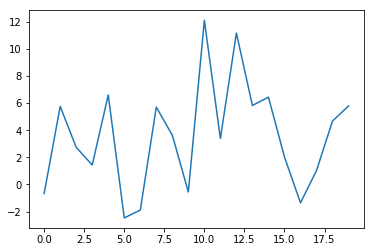

In [8]:
dataset = np.random.randn(20, 2)*10
df_dataset = pd.DataFrame(dataset)
df_dataset.head()
 
X1 = (np.array(dataset[:,0])).reshape(-1, 1)
X2 = (np.array(dataset[:,1])).reshape(-1, 1)
Y = 0.5*X1 + np.square(X2*0.1) + 5*np.random.randn(1)

# Visualize the output
fig = plt.figure()
df_Y = pd.DataFrame(Y)
dataframe = pd.concat([df_dataset[0], df_dataset[1], df_Y], axis=1)
dataframe.columns = ['X1', 'X2', 'Y']
print('Quick view of out output')
dataframe.Y.plot()

scalerX1 = preprop.MinMaxScaler()
scalerX2 = preprop.MinMaxScaler()
scalerY  = preprop.MinMaxScaler()

x1 = scalerX1.fit_transform(X1)
x2 = scalerX2.fit_transform(X2)
y  = scalerY.fit_transform(Y)

x = np.concatenate((x1, x2), axis=1)

## Create object Neural Network, train and predict

Loss after iteration 0: 12.050295
Loss after iteration 100: 1.288042
Loss after iteration 200: 1.150051
Loss after iteration 300: 1.024793
Loss after iteration 400: 0.900789
Loss after iteration 500: 0.773390
Loss after iteration 600: 0.643243
Loss after iteration 700: 0.516098
Loss after iteration 800: 0.401180
Loss after iteration 900: 0.307058
Loss after iteration 1000: 0.237408
Loss after iteration 1100: 0.190158
Loss after iteration 1200: 0.159964
Loss after iteration 1300: 0.141154
Loss after iteration 1400: 0.129307
Loss after iteration 1500: 0.121509
Loss after iteration 1600: 0.116023
Loss after iteration 1700: 0.111870
Loss after iteration 1800: 0.108513
Loss after iteration 1900: 0.105656


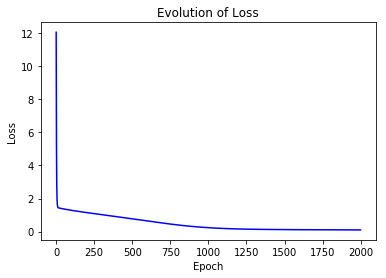

RMSE = 1.05


In [9]:
network = Net(inputLayerSize=2, hiddenLayerSize=3, outputLayerSize=1)
network.train(x, y, epochs=2000, learning_rate=0.01, reg_lambda=0.01, print_loss=True)

predictions = network.feed_forward(x)
predictions = scalerY.inverse_transform(predictions)
RMSE = rmse(predictions, Y)
print('RMSE = %.2f' % (RMSE[0]))

### Check Prediciton Accuracy on Training Set

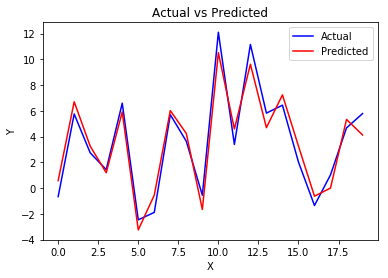

In [11]:
plt.figure()
plt.title('Actual vs Predicted')
plt.ylabel('Y')
plt.xlabel('X')
plt.plot(Y, 'b-', label='Actual')
plt.plot(predictions, 'r-', label='Predicted')
plt.legend()
plt.show()

### Training set

Quick view of out output


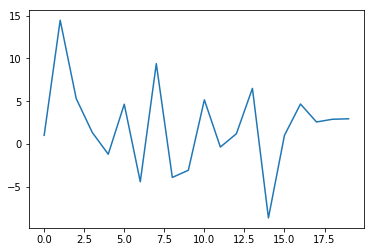

In [12]:
np.random.seed(2018)
dataset = np.random.randn(20, 2)*10
df_dataset = pd.DataFrame(dataset)
df_dataset.head()
 
X1 = (np.array(dataset[:,0])).reshape(-1, 1)
X2 = (np.array(dataset[:,1])).reshape(-1, 1)
Y = 0.5*X1 + np.square(X2*0.1) + 5*np.random.randn(1)

# Visualize the output
fig = plt.figure()
df_Y = pd.DataFrame(Y)
dataframe = pd.concat([df_dataset[0], df_dataset[1], df_Y], axis=1)
dataframe.columns = ['X1', 'X2', 'Y']
print('Quick view of out output')
dataframe.Y.plot()

scalerX1 = preprop.MinMaxScaler()
scalerX2 = preprop.MinMaxScaler()
scalerY  = preprop.MinMaxScaler()

x1 = scalerX1.fit_transform(X1)
x2 = scalerX2.fit_transform(X2)
y  = scalerY.fit_transform(Y)

x = np.concatenate((x1, x2), axis=1)

Loss after iteration 0: 0.204036
Loss after iteration 100: 0.072947
Loss after iteration 200: 0.051648
Loss after iteration 300: 0.042820
Loss after iteration 400: 0.038940
Loss after iteration 500: 0.037006
Loss after iteration 600: 0.035852
Loss after iteration 700: 0.035027
Loss after iteration 800: 0.034354
Loss after iteration 900: 0.033763
Loss after iteration 1000: 0.033222
Loss after iteration 1100: 0.032717
Loss after iteration 1200: 0.032240
Loss after iteration 1300: 0.031787
Loss after iteration 1400: 0.031355
Loss after iteration 1500: 0.030942
Loss after iteration 1600: 0.030547
Loss after iteration 1700: 0.030169
Loss after iteration 1800: 0.029805
Loss after iteration 1900: 0.029457


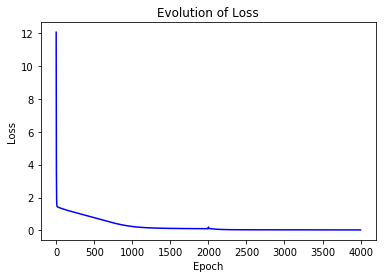

RMSE = 0.88


In [13]:
network.train(x, y, epochs=2000, learning_rate=0.01, reg_lambda=0.01, print_loss=True)

predictions = network.feed_forward(x)
predictions = scalerY.inverse_transform(predictions)
RMSE = rmse(predictions, Y)
print('RMSE = %.2f' % (RMSE[0]))

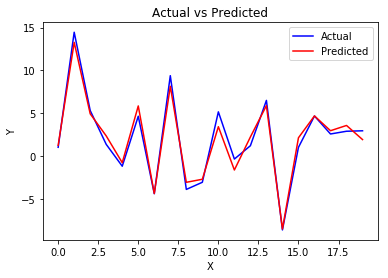

In [14]:
plt.figure()
plt.title('Actual vs Predicted')
plt.ylabel('Y')
plt.xlabel('X')
plt.plot(Y, 'b-', label='Actual')
plt.plot(predictions, 'r-', label='Predicted')
plt.legend()
plt.show()